In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# reading the csv file
df = pd.read_csv('DATA.csv')
print(df.shape)
df.head()

(147049, 5)


,user_id,order_id,time,service_id,basket
0,33,1,1/28/2016 15:33,1,12500
1,33,2,1/28/2016 22:23,1,33000
2,138,3,1/29/2016 19:27,1,40850
3,55,4,1/29/2016 20:17,1,27500
4,8,5,1/30/2016 14:06,1,32000


In [4]:
# Counting Null values in df
sum_nan = 0
for col in list(df.columns):
    if any(df[col].isnull()):
        sum_nan = sum_nan + 1
print('there is {} NULL value(s)'.format(sum_nan))

there is 0 NULL value(s)


<AxesSubplot:>

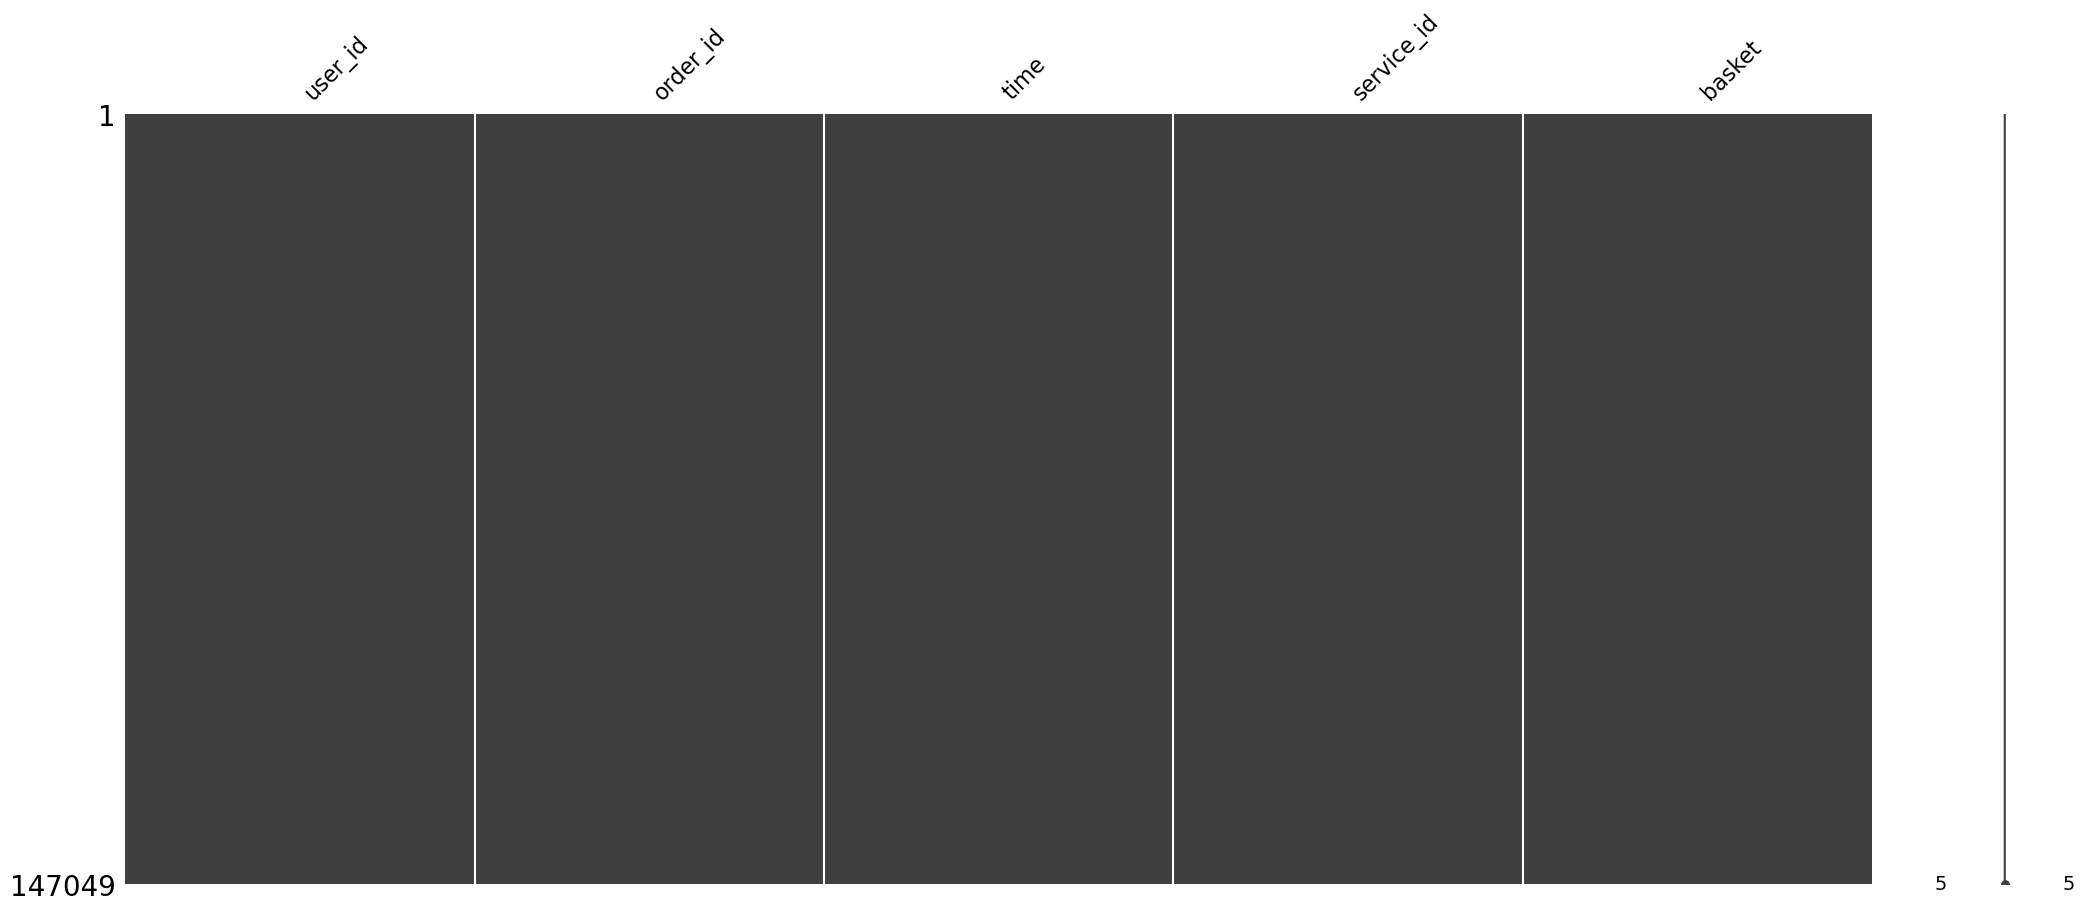

In [5]:
msno.matrix(df)

In [25]:
# Checking Dtype of coulmns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147049 entries, 0 to 147048
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     147049 non-null  int64 
 1   order_id    147049 non-null  int64 
 2   time        147049 non-null  object
 3   service_id  147049 non-null  int64 
 4   basket      147049 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 5.6+ MB


In [26]:
# Changing "time" column data type to "datetime"
df['time'] = pd.to_datetime(df['time'])
max_time = df['time'].max()
print(max_time)

2020-12-18 23:42:00


In [27]:
# Grouping df by user_id
df2 = df.groupby(['user_id']).agg({'basket': sum , 'order_id' : lambda x:len(x) ,'time' : lambda x : (max_time - x.max()).days})
df2.head()

,basket,order_id,time
user_id,,,
1,67252275,1444,0
2,39750,2,704
3,1240015,25,56
4,248000,2,502
5,145800,5,1431


In [28]:
# renaming the coulmn's names
df2.rename(columns = {'time':'Recency' , 'order_id':'Frequency' , 'basket':'Monetary' , 'user_id':'Customer'} , inplace = True)
df2.head()

,Monetary,Frequency,Recency
user_id,,,
1,67252275,1444,0
2,39750,2,704
3,1240015,25,56
4,248000,2,502
5,145800,5,1431


In [29]:
# choosing quantiles
quantiles = df2.quantile(q = [0.25,0.5,0.75])

In [30]:
quantiles

,Monetary,Frequency,Recency
0.25,36500.0,1.0,30.0
0.50,102725.0,2.0,210.5
0.75,408912.5,9.0,458.0


In [31]:
# defining "RScoring" function for scoring Recency

def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else: 
        return 4

In [32]:
# defining "MFScoring" function for scoring Monetary and Frequency

def MFScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else: 
        return 1    

In [33]:
# adding "R" and "F" and "M" columns which show "Recency", "Frequency" and "Monetary" rank of each row respectively
df2['R'] = df2['Recency'].apply(RScoring , args = ('Recency',quantiles,))
df2['F'] = df2['Frequency'].apply(MFScoring , args = ('Frequency',quantiles,))
df2['M'] = df2['Monetary'].apply(MFScoring , args = ('Monetary',quantiles,))
df2.head()

,Monetary,Frequency,Recency,R,F,M
user_id,,,,,,
1,67252275,1444,0,1,1,1
2,39750,2,704,4,3,3
3,1240015,25,56,2,1,1
4,248000,2,502,4,3,2
5,145800,5,1431,4,2,2


In [34]:
# Adding RFMScore which is sum of scores
df2['RFMScore'] = df2[['R','F','M']].sum(axis=1)
df2.head()

,Monetary,Frequency,Recency,R,F,M,RFMScore
user_id,,,,,,,
1,67252275,1444,0,1,1,1,3
2,39750,2,704,4,3,3,10
3,1240015,25,56,2,1,1,4
4,248000,2,502,4,3,2,9
5,145800,5,1431,4,2,2,8


In [35]:
loyalty_level = ['Platinum','Gold','Silver','Bronze']
score_cuts = pd.qcut(df2.RFMScore, q = 4 , labels = loyalty_level)
df2['RFMS_Loyalty_Level']  = score_cuts.values
df2.reset_index().head()

,user_id,Monetary,Frequency,Recency,R,F,M,RFMScore,RFMS_Loyalty_Level
0,1,67252275,1444,0,1,1,1,3,Platinum
1,2,39750,2,704,4,3,3,10,Silver
2,3,1240015,25,56,2,1,1,4,Platinum
3,4,248000,2,502,4,3,2,9,Silver
4,5,145800,5,1431,4,2,2,8,Gold


In [37]:
df2.RFMS_Loyalty_Level.value_counts()

Platinum    2936
Gold        2667
Bronze      2343
Silver      2052
Name: RFMS_Loyalty_Level, dtype: int64

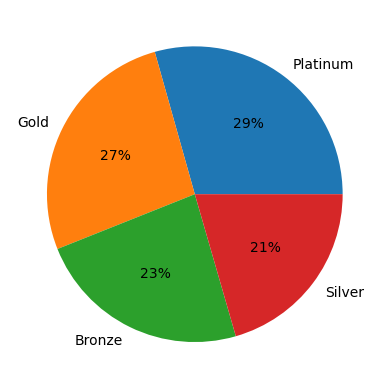

In [36]:
# Visualizing RFM Analysis Result
plt.pie(df2.RFMS_Loyalty_Level.value_counts() , labels = df2.RFMS_Loyalty_Level.value_counts().index , autopct = '%.0f%%')
plt.show()